# Apply morphological operations as post-processing on predicted masks

In [85]:
# IMPORTS

import numpy as np
from pathlib import Path
import glob2
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.visualization.visualization_fct import mask_to_rgb

# CONSTANTS

path = '../data/raw/carseg_data/clean_data/'
path_predictions = '../data/predictions/unet_finetuned_v9_data_augmented_valid/'

In [7]:
# NB OF FILES IN CLEAN DATASET: 3521

all_paths = [ Path(p).absolute() for p in glob2.glob(path + '*') ]
print('Number of files:', len(all_paths))
assert len(all_paths) == 3521

Number of files: 3521


In [8]:
# load all files
all_files = [np.load(f) for f in all_paths]
all_stems = np.array([f.stem for f in all_paths])

In [31]:
# load predictions

all_predictions_paths = [ Path(p).absolute() for p in glob2.glob(path_predictions + '*') ]
all_predictions = [np.load(f) for f in all_predictions_paths]
all_predictions_stems = np.array([f.stem for f in all_predictions_paths])
print('Number of files:', len(all_predictions_paths))

Number of files: 215


index_pred: 156
Selected file: 940
[0.0, 1.0, 2.0, 3.0, 4.0, 7.0, 8.0]
Shape img: (256, 256, 3)


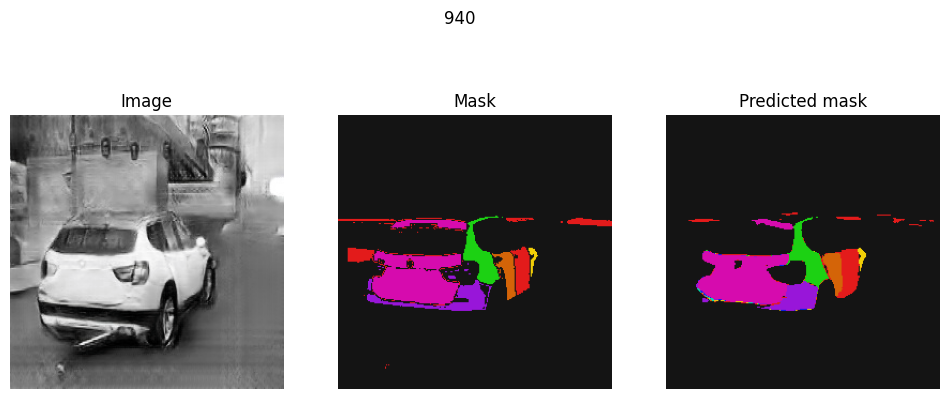

In [232]:
# see a random picture

index_pred = np.random.randint(len(all_predictions_paths)) 
stem_ex = all_predictions_stems[index_pred]
print('index_pred:', index_pred)
print('Selected file:', stem_ex)

index = np.argwhere(all_stems == stem_ex)[0][0]
img_ex = all_files[index]

labels_in_img = list(set(img_ex[3].flatten()))
print(labels_in_img)

anImage = (np.transpose(img_ex[:3], (1, 2, 0))*255).astype(int)
print('Shape img:', anImage.shape)

plt.figure(figsize=(12,5), facecolor='white')
plt.suptitle(stem_ex)

plt.subplot(1,3,1)
plt.title('Image')
plt.imshow(anImage) 
plt.axis(False)

plt.subplot(1,3,2)
plt.title('Mask')
plt.imshow(mask_to_rgb(img_ex[3]), cmap='jet')
plt.axis(False)

plt.subplot(1,3,3)
plt.title('Predicted mask')
plt.imshow(mask_to_rgb(all_predictions[index_pred]), cmap='jet')
plt.axis(False)


plt.show()

## Morphology: opening

In [206]:
import cv2
from torchmetrics.functional import dice
import torch

RECALL:
```python
_MASK_NAMES_ ={
    0:'background', #black #background
    1:'front_door', #red #front_door
    2:'back_door', #orange #back_door
    3:'front_side', #yellow #front_side
    4:'back_side', #green #back_side
    5:'front_bumper ', #turquoise #front_bumper 
    6:'bonnet', #blue #bonnet #capot
    7:'back_bumper', #purple #back_bumper
    8:'trunk', #pink #trunk #coffre
}
```

In [233]:
selected_class = 2

kernel_type_opening = cv2.MORPH_ELLIPSE #cv2.MORPH_CROSS  cv2.MORPH_RECT cv2.MORPH_ELLIPSE
kernel_size_opening = 3

kernel_type_closing = cv2.MORPH_ELLIPSE #cv2.MORPH_CROSS  cv2.MORPH_RECT cv2.MORPH_ELLIPSE
kernel_size_closing = 3

In [234]:
binary_mask = img_ex[3]==selected_class
predicted_binary_mask = all_predictions[index_pred] == selected_class

kernel_opening = cv2.getStructuringElement(kernel_type_opening,(kernel_size_opening,kernel_size_opening))
kernel_closing = cv2.getStructuringElement(kernel_type_closing,(kernel_size_closing,kernel_size_closing))

opening = cv2.morphologyEx(predicted_binary_mask.astype(float), cv2.MORPH_OPEN, kernel_opening)
processed_binary_mask = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_closing)

# compare efficiency of opening morphological operation

dice_before = dice(torch.IntTensor(predicted_binary_mask), torch.IntTensor(binary_mask)).detach().numpy()
dice_after = dice(torch.IntTensor(processed_binary_mask), torch.IntTensor(binary_mask)).detach().numpy()
print('DICE before opening:\t',dice_before)
print('DICE after opening:\t',dice_after)

print('Progress:\t\t', round(100*(dice_after-dice_before)/dice_before, 2),'%')

DICE before opening:	 0.9973602
DICE after opening:	 0.9976349
Progress:		 0.03 %


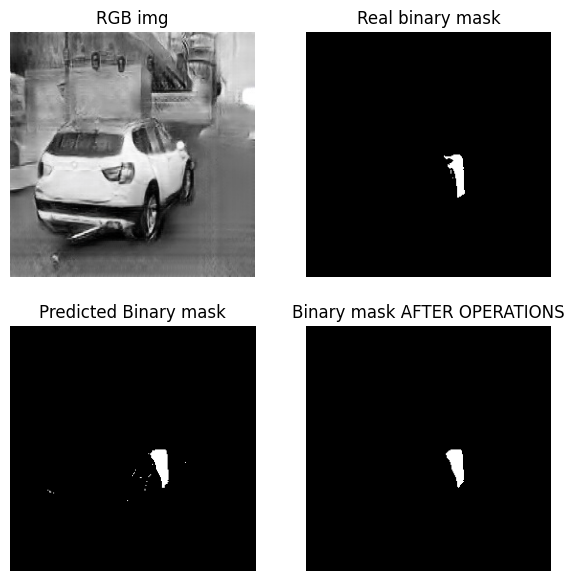

In [235]:
plt.figure(figsize=(7,7), facecolor='white')

plt.subplot(2,2,1)
plt.imshow(anImage) 
plt.axis(False)
plt.title('RGB img')

plt.subplot(2,2,2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Real binary mask')
plt.axis(False)

plt.subplot(2,2,3)
plt.imshow(predicted_binary_mask, cmap='gray')
plt.title('Predicted Binary mask')
plt.axis(False)

plt.subplot(2,2,4)
plt.imshow(processed_binary_mask, cmap='gray')
plt.title('Binary mask AFTER OPERATIONS')
plt.axis(False)

plt.show()

**TODO**

- recombine all openings based on class frequency (?)
- find the best kernel for each class
- apply the best post-processing operations on the test set

### 1. Find the best operations and kernels for each class